```{contents}
```
## ReAct Loop

The **ReAct loop (Reason → Act → Observe)** is a core control pattern for building **autonomous, tool-using agents** in LangGraph.
It combines **structured reasoning**, **tool execution**, and **environment feedback** into a **cyclic state machine**.

---

### **1. Motivation**

Single-pass LLM calls are insufficient for complex tasks because:

* The model must **reason** about the problem
* **act** by invoking tools
* **observe** the results
* **revise** its plan
* and **repeat** until a goal is reached

LangGraph expresses this explicitly using a **cyclic graph**.

---

### **2. Conceptual Flow**

```
┌─────────┐
│ Reason  │
└────┬────┘
     ↓
┌─────────┐
│  Act    │
└────┬────┘
     ↓
┌─────────┐
│ Observe │
└────┬────┘
     ↓
 (Termination Check)
     ↺
```

---

### **3. State Design**

```python
class State(TypedDict):
    task: str
    thought: str
    action: str
    observation: str
    done: bool
```

This shared state enables **memory, feedback, and convergence**.

---

### **4. Node Responsibilities**

| Node    | Role                              |
| ------- | --------------------------------- |
| Reason  | Analyze problem, decide next step |
| Act     | Execute chosen tool or action     |
| Observe | Interpret tool output             |
| Router  | Decide whether to continue        |

---

### **5. Minimal Working Example**

```python
from langgraph.graph import StateGraph, END
from typing import TypedDict

class State(TypedDict):
    task: str
    step: int
    done: bool

def reason(state):
    print("Reasoning...")
    return {"step": state["step"] + 1}

def act(state):
    print("Acting...")
    return {}

def observe(state):
    print("Observing...")
    if state["step"] >= 3:
        return {"done": True}
    return {"done": False}

def route(state):
    return END if state["done"] else "reason"

builder = StateGraph(State)

builder.add_node("reason", reason)
builder.add_node("act", act)
builder.add_node("observe", observe)

builder.set_entry_point("reason")
builder.add_edge("reason", "act")
builder.add_edge("act", "observe")
builder.add_conditional_edges("observe", route, {
    "reason": "reason",
    END: END
})

graph = builder.compile()
graph.invoke({"task": "demo", "step": 0, "done": False})
```

---

### **6. Production ReAct with Tools**

```python
def act(state):
    tool_result = search_tool(state["thought"])
    return {"observation": tool_result}
```

This integrates **external knowledge and actions**.

---

### **7. Termination Control**

| Mechanism            | Purpose                |
| -------------------- | ---------------------- |
| Max steps            | Prevent infinite loops |
| Confidence threshold | Stop when goal reached |
| Human approval       | Safety gate            |
| Timeout              | Kill hung processes    |

```python
graph.invoke(input, config={"recursion_limit": 10})
```

---

### **8. Variants of ReAct**

| Variant          | Description             |
| ---------------- | ----------------------- |
| ReAct            | Basic reasoning + tools |
| Plan-Act-Observe | Adds planning stage     |
| Reflect-Act      | Adds self-critique      |
| ReAct++          | Multi-agent ReAct       |
| Safe-ReAct       | Human approval gate     |

---

### **9. Why LangGraph is Ideal for ReAct**

| Without LangGraph | With LangGraph         |
| ----------------- | ---------------------- |
| Implicit loops    | Explicit state machine |
| Hidden memory     | Typed shared state     |
| Fragile control   | Deterministic control  |
| Hard to debug     | Visual + traceable     |

---

### **10. Mental Model**

LangGraph implements ReAct as a **closed-loop control system**:

> **State → Decision → Action → Feedback → State**

This is the foundation of **autonomous intelligent systems**.



### Demonstration

In [1]:
# ReAct Loop in LangGraph — Single Cell Demonstration

from typing import TypedDict
from langgraph.graph import StateGraph, END

# ----------- State Definition -----------

class State(TypedDict):
    task: str
    step: int
    thought: str
    observation: str
    done: bool

# ----------- Nodes -----------

def reason(state: State):
    return {
        "thought": f"Thinking about step {state['step']} for: {state['task']}",
        "step": state["step"] + 1
    }

def act(state: State):
    return {
        "observation": f"Performed action based on: {state['thought']}"
    }

def observe(state: State):
    if state["step"] >= 3:
        return {"done": True}
    return {"done": False}

def route(state: State):
    return END if state["done"] else "reason"

# ----------- Graph Construction -----------

builder = StateGraph(State)

builder.add_node("reason", reason)
builder.add_node("act", act)
builder.add_node("observe", observe)

builder.set_entry_point("reason")
builder.add_edge("reason", "act")
builder.add_edge("act", "observe")

builder.add_conditional_edges("observe", route, {
    "reason": "reason",
    END: END
})

# ----------- Compile & Run -----------

graph = builder.compile()

result = graph.invoke({
    "task": "Analyze sales data",
    "step": 0,
    "thought": "",
    "observation": "",
    "done": False
})

print(result)


{'task': 'Analyze sales data', 'step': 3, 'thought': 'Thinking about step 2 for: Analyze sales data', 'observation': 'Performed action based on: Thinking about step 2 for: Analyze sales data', 'done': True}


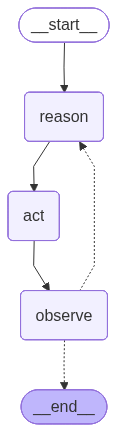

In [2]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())